In [20]:
import tensorflow.keras as k
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import neural_net_project_auxiliary as nn
DM = nn.DataManipulator
from ipywidgets import interact, interactive, FloatSlider, VBox
from IPython.display import display, clear_output

In [21]:
os.chdir("/")
for root, dirs, files in os.walk('.'):
    if 'models' in dirs:
        found_dir_path = os.path.join(root, 'models')
os.chdir(found_dir_path)

model_abs_77K = tf.keras.models.load_model('final_abs_spectra_from_params_7_pigs_dis_120_77K', compile=False)
model_abs_290K = tf.keras.models.load_model('final_abs_spectra_from_params_7_pigs_dis_120_290K', compile=False)
model_array = np.array([[model_abs_77K, model_abs_290K]])

In [22]:
os.chdir("/")
for root, dirs, files in os.walk('.'):
    if 'statistical_props' in dirs:
        found_dir_path = os.path.join(root, 'statistical_props')
os.chdir(found_dir_path)

par_means, par_stds, spec_means, spec_stds,  = np.empty((2,2), dtype=object), np.empty((2,2), dtype=object),\
                                               np.empty((2,2), dtype=object), np.empty((2,2), dtype=object)
for ss, spec in enumerate(['abs']):
    for tt, temp in enumerate(['77K', '290K']): 
        par_means[ss, tt] = np.load(f'params_mean_7pigs_dis120_{spec}_{temp}.npy')
        spec_means[ss, tt] = np.load(f'spectra_mean_7pigs_dis120_{spec}_{temp}.npy')
        par_stds[ss, tt] = np.load(f'params_std_7pigs_dis120_{spec}_{temp}.npy')
        spec_stds[ss, tt] = np.load(f'spectra_std_7pigs_dis120_{spec}_{temp}.npy')

1/1 [==============================] - 1s 551ms/step


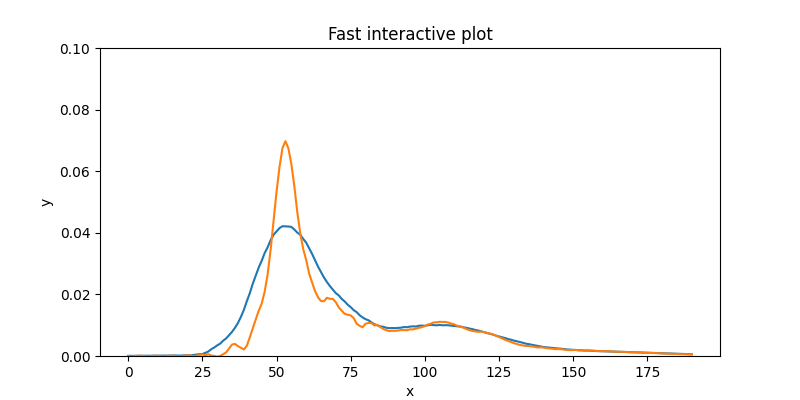

In [23]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, FloatSlider, VBox
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib widget

# --- Create figure once ---
fig, ax = plt.subplots(figsize=(8, 4))
x = np.linspace(0,190,191)
line1, = ax.plot(x, np.zeros_like(x))
line2, = ax.plot(x, np.zeros_like(x))
ax.set_title("Fast interactive plot")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(0, 0.1)
fig.canvas.draw_idle()

RNG = np.random.default_rng()
os.chdir("/")
for root, dirs, files in os.walk('.'):
    if 'statistical_props' in dirs:
        found_dir_path = os.path.join(root, 'statistical_props')
os.chdir(found_dir_path)
os.chdir("../")
Ham = np.load('FMO_Ham.npy')
dipole_moments = np.load('FMO_3eni_dmoms.npy')
site_dip_factor = dipole_moments@dipole_moments.T
site_dip_factor_max = np.amax(np.abs(site_dip_factor))
site_dip_factor /= site_dip_factor_max
number_of_pigments  = 7

def update_plot(change=None):
    """
    This function will be called whenever any slider changes.
    It receives the current slider values, computes something,
    and updates the plot.
    """
    # Example: use slider values to generate a simple curve

    energies = [slider.value for slider in sliders]
    Ham[np.diag_indices_from(Ham)] = energies
    exciton_ens, SS = np.linalg.eigh(Ham)     
    gamma_aamm = (SS**2).T@(SS**2)
    C_coeffs = SS.flatten()                        
    ex_dip_factor = np.diag((SS.T)@site_dip_factor@SS)
    params = np.concatenate((exciton_ens,\
                         (gamma_aamm[np.triu_indices_from(gamma_aamm)]).flatten(),\
                           ex_dip_factor, C_coeffs))
    
    params_290_abs = DM.stat_normalise(params,  mean=par_means[0,1], std=par_stds[0,1])
    predicted_spec_290_abs = DM.stat_denormalise(model_array[0, 1].predict(np.array([params_290_abs]))[0], mean=spec_means[0,1], std=spec_stds[0,1])   

    params_77_abs = DM.stat_normalise(params,  mean=par_means[0,0], std=par_stds[0,0])
    predicted_spec_77_abs = DM.stat_denormalise(model_array[0, 0].predict(np.array([params_77_abs]))[0], mean=spec_means[0,0], std=spec_stds[0,0])    
    # Clear previous plot and draw new
    line1.set_ydata(predicted_spec_290_abs)
    line2.set_ydata(predicted_spec_77_abs)
    fig.canvas.draw_idle()   # very fast redraw

# --- Sliders ---
sliders = [
    widgets.FloatSlider(value=600, min=0, max=1400, step=20, description=f"S{i+1}")
    for i in range(7)
]

for slider in sliders:
    slider.observe(update_plot, names="value")
    
# Initial draw
update_plot()

# Display sliders
display(widgets.VBox(sliders))